<a href="https://colab.research.google.com/github/elenachau/cv-pytorch/blob/main/training_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing Darknet

In [8]:
import os
if not os.path.exists('darknet'):
    !git clone https://github.com/AlexeyAB/darknet
    %cd darknet

    !apt-get update
    !apt-get install -y libopencv-dev

    # reconfigure maekfile
    !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
    # !!! if no GPU, comment out below 3 lines !!! 
    !sed -i 's/GPU=0/GPU=1/' Makefile
    !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
    !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
    !make # compile darknet source code
    !pip install -q torch_snippets

    # download and extract dataset, remove ZIP to save space
    !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
    !tar -xf open-images-bus-trucks.tar.xz

    # fetch pre-trained weights to make sample prediction
    !rm open-images-bus-trucks.tar.xz
    !wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

Cloning into 'darknet'...
remote: Enumerating objects: 15909, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 15909 (delta 2), reused 2 (delta 2), pack-reused 15903 (from 2)
Receiving objects: 100% (15909/15909), 14.46 MiB | 6.52 MiB/s, done.
Resolving deltas: 100% (10705/10705), done.
/content/darknet
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,149 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:

In [10]:
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/person.jpg # predict with network and pre-trained weights

 CUDA-version: 12050 (12040)
, cuDNN: 9.2.1, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv  

### Create Ground Truths for Custom Dataset

In [12]:
# text file containing class names
%%writefile data/obj.names
bus
truck

Writing data/obj.names


In [13]:
# text file of parameters in dataset and file locations
%%writefile data/obj.data
classes = 2
train = data/train.txt
valid = data/val.txt
names = data/obj.names
backup = backup/

Writing data/obj.data


In [14]:
# move images and ground truth text files to data/obj folder
!mkdir -p data/obj
!cp -r open-images-bus-trucks/images/* data/obj/
!cp -r open-images-bus-trucks/yolo_labels/all/{train,val}.txt data/
!cp -r open-images-bus-trucks/yolo_labels/all/labels/*.txt data/obj/

In [16]:
# create a copy of existing configuration and modify it in place
!cp cfg/yolov4-tiny-custom.cfg cfg/yolov4-tiny-bus-trucks.cfg
# max_batches to 4000 (since the dataset is small enough)
!sed -i 's/max_batches = 500200/max_batches=4000/' cfg/yolov4-tiny-bus-trucks.cfg
# number of sub-batches per batch
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov4-tiny-bus-trucks.cfg
# number of batches after which learning rate is decayed
!sed -i 's/steps=400000,450000/steps=3200,3600/' cfg/yolov4-tiny-bus-trucks.cfg
# number of classes is 2 as opposed to 80 (which is the number of COCO classes)
!sed -i 's/classes=80/classes=2/g' cfg/yolov4-tiny-bus-trucks.cfg
# in the classification and regression heads, change number of output convolution filters
# from 255 -> 21 and 57 -> 33, since we have fewer classes we don't need as many filters
!sed -i 's/filters=255/filters=21/g' cfg/yolov4-tiny-bus-trucks.cfg
!sed -i 's/filters=57/filters=33/g' cfg/yolov4-tiny-bus-trucks.cfg

In [17]:
!wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29
!cp yolov4-tiny.conv.29 build/darknet/x64/

In [18]:
!./darknet detector train data/obj.data cfg/yolov4-tiny-bus-trucks.cfg yolov4-tiny.conv.29 -dont_show -mapLastAt

Streaming output truncated to the last 5000 lines.
 total_bbox = 312305, rewritten_bbox = 0.243992 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.832984), count: 5, class_loss = 0.710236, iou_loss = 0.258937, total_loss = 0.969174 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.603294), count: 1, class_loss = 0.254479, iou_loss = 4.658234, total_loss = 4.912713 
 total_bbox = 312311, rewritten_bbox = 0.243988 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.826092), count: 5, class_loss = 0.448137, iou_loss = 0.276880, total_loss = 0.725017 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.620306), count: 1, class_loss = 0.465250, iou_loss = 1.064866, total_loss = 1.530116 
 total_bbox = 312317, rewritten_bbox = 0.243983 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.789930), count: 4, class_loss = 0.538152, 

In [46]:
# check if the folder exists
!ls -d images-of-trucks-and-busses

images-of-trucks-and-busses


In [47]:
import os
from google.colab import files

os.makedirs('images-of-trucks-and-busses', exist_ok=True)

print("Upload your image file now:")
uploaded = files.upload()

Upload your image file now:


Saving 2023-chevy-silverado-1500-profile.jpeg to 2023-chevy-silverado-1500-profile.jpeg


In [48]:
# move the uploaded file into the target directory
for filename in uploaded.keys():
    destination = os.path.join('images-of-trucks-and-busses', filename)
    os.rename(filename, destination)
    print(f"Moved {filename} to {destination}")

Moved 2023-chevy-silverado-1500-profile.jpeg to images-of-trucks-and-busses/2023-chevy-silverado-1500-profile.jpeg


 CUDA-version: 12050 (12040)
, cuDNN: 9.2.1, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	   

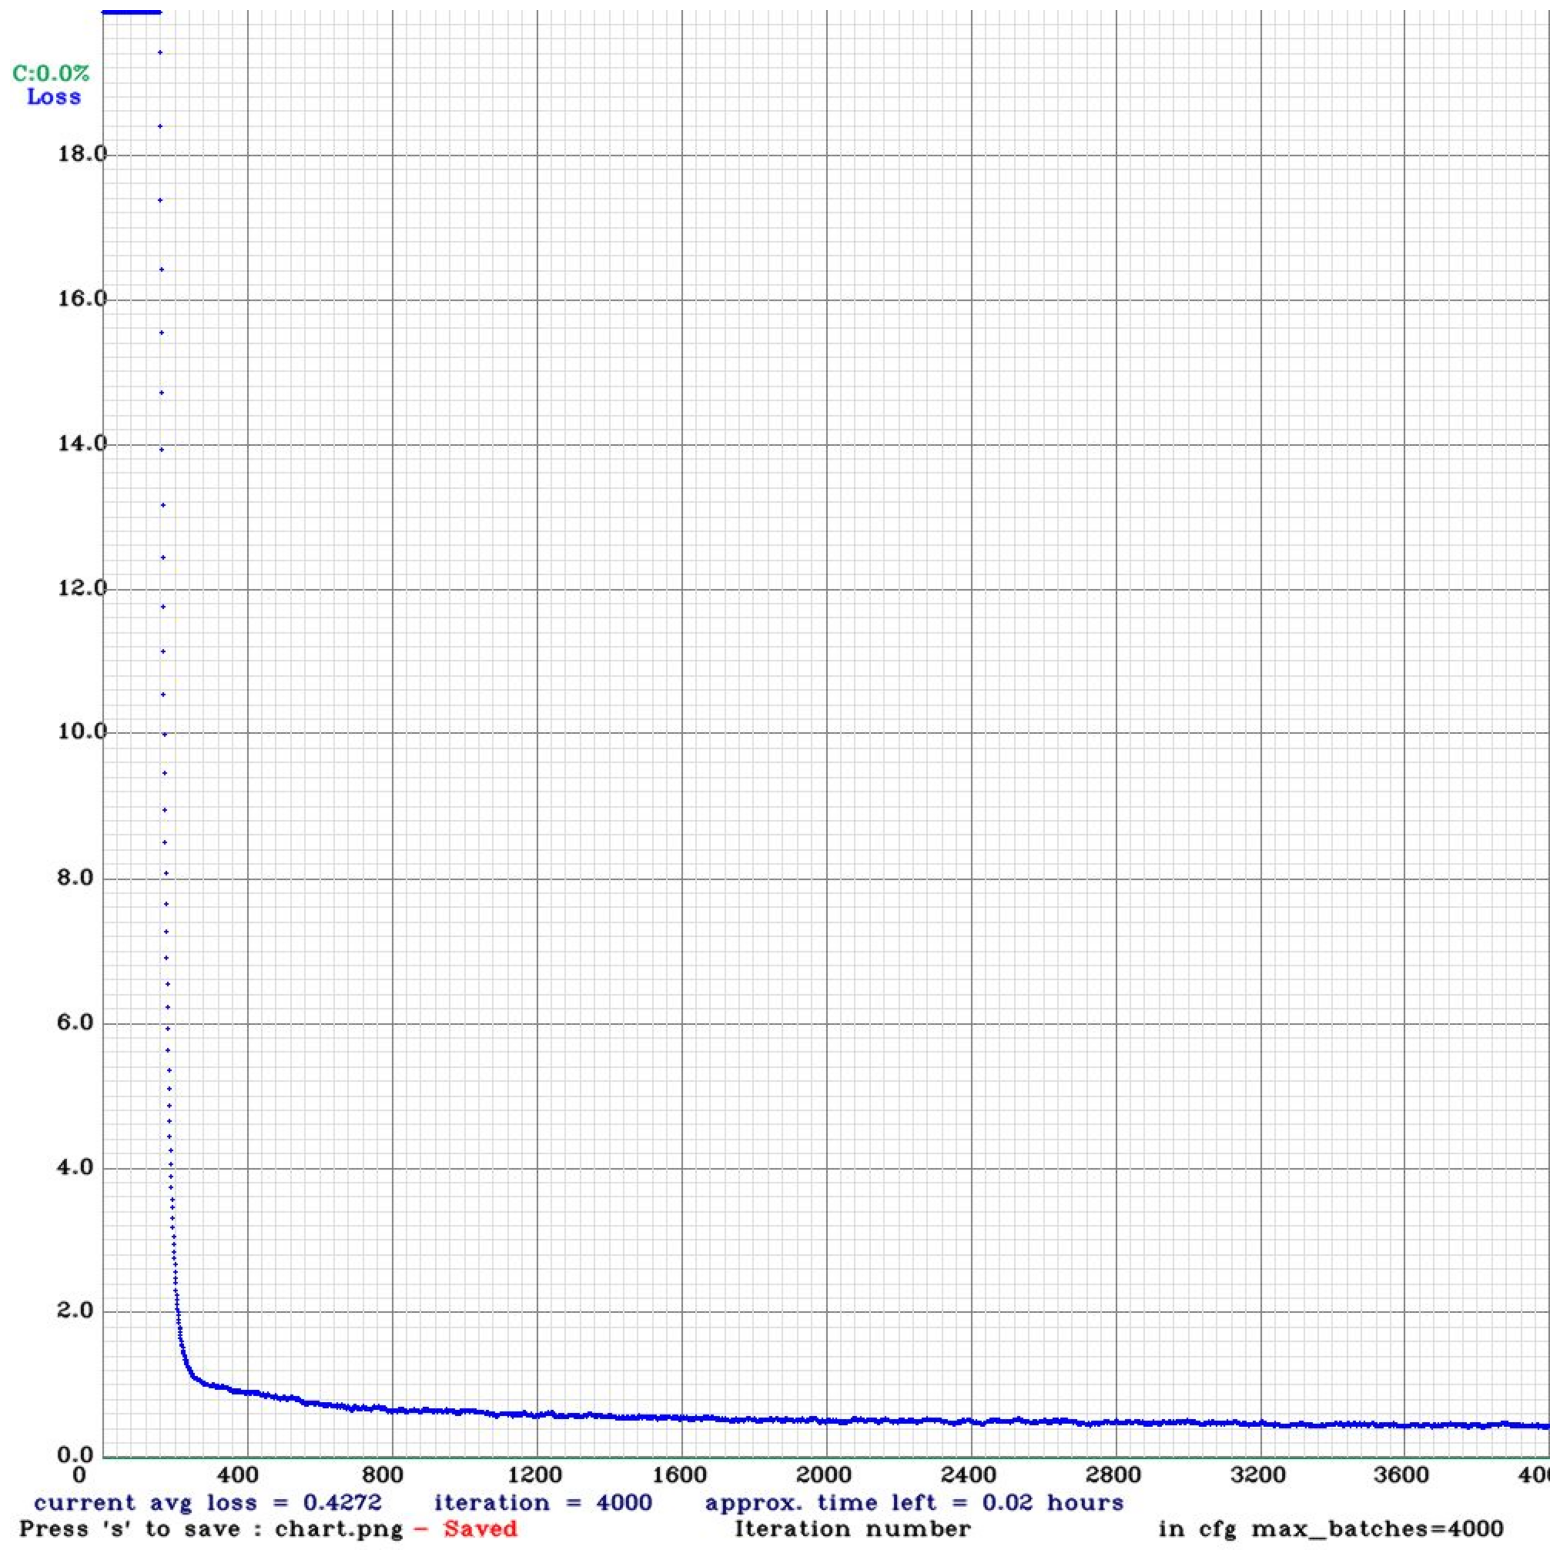

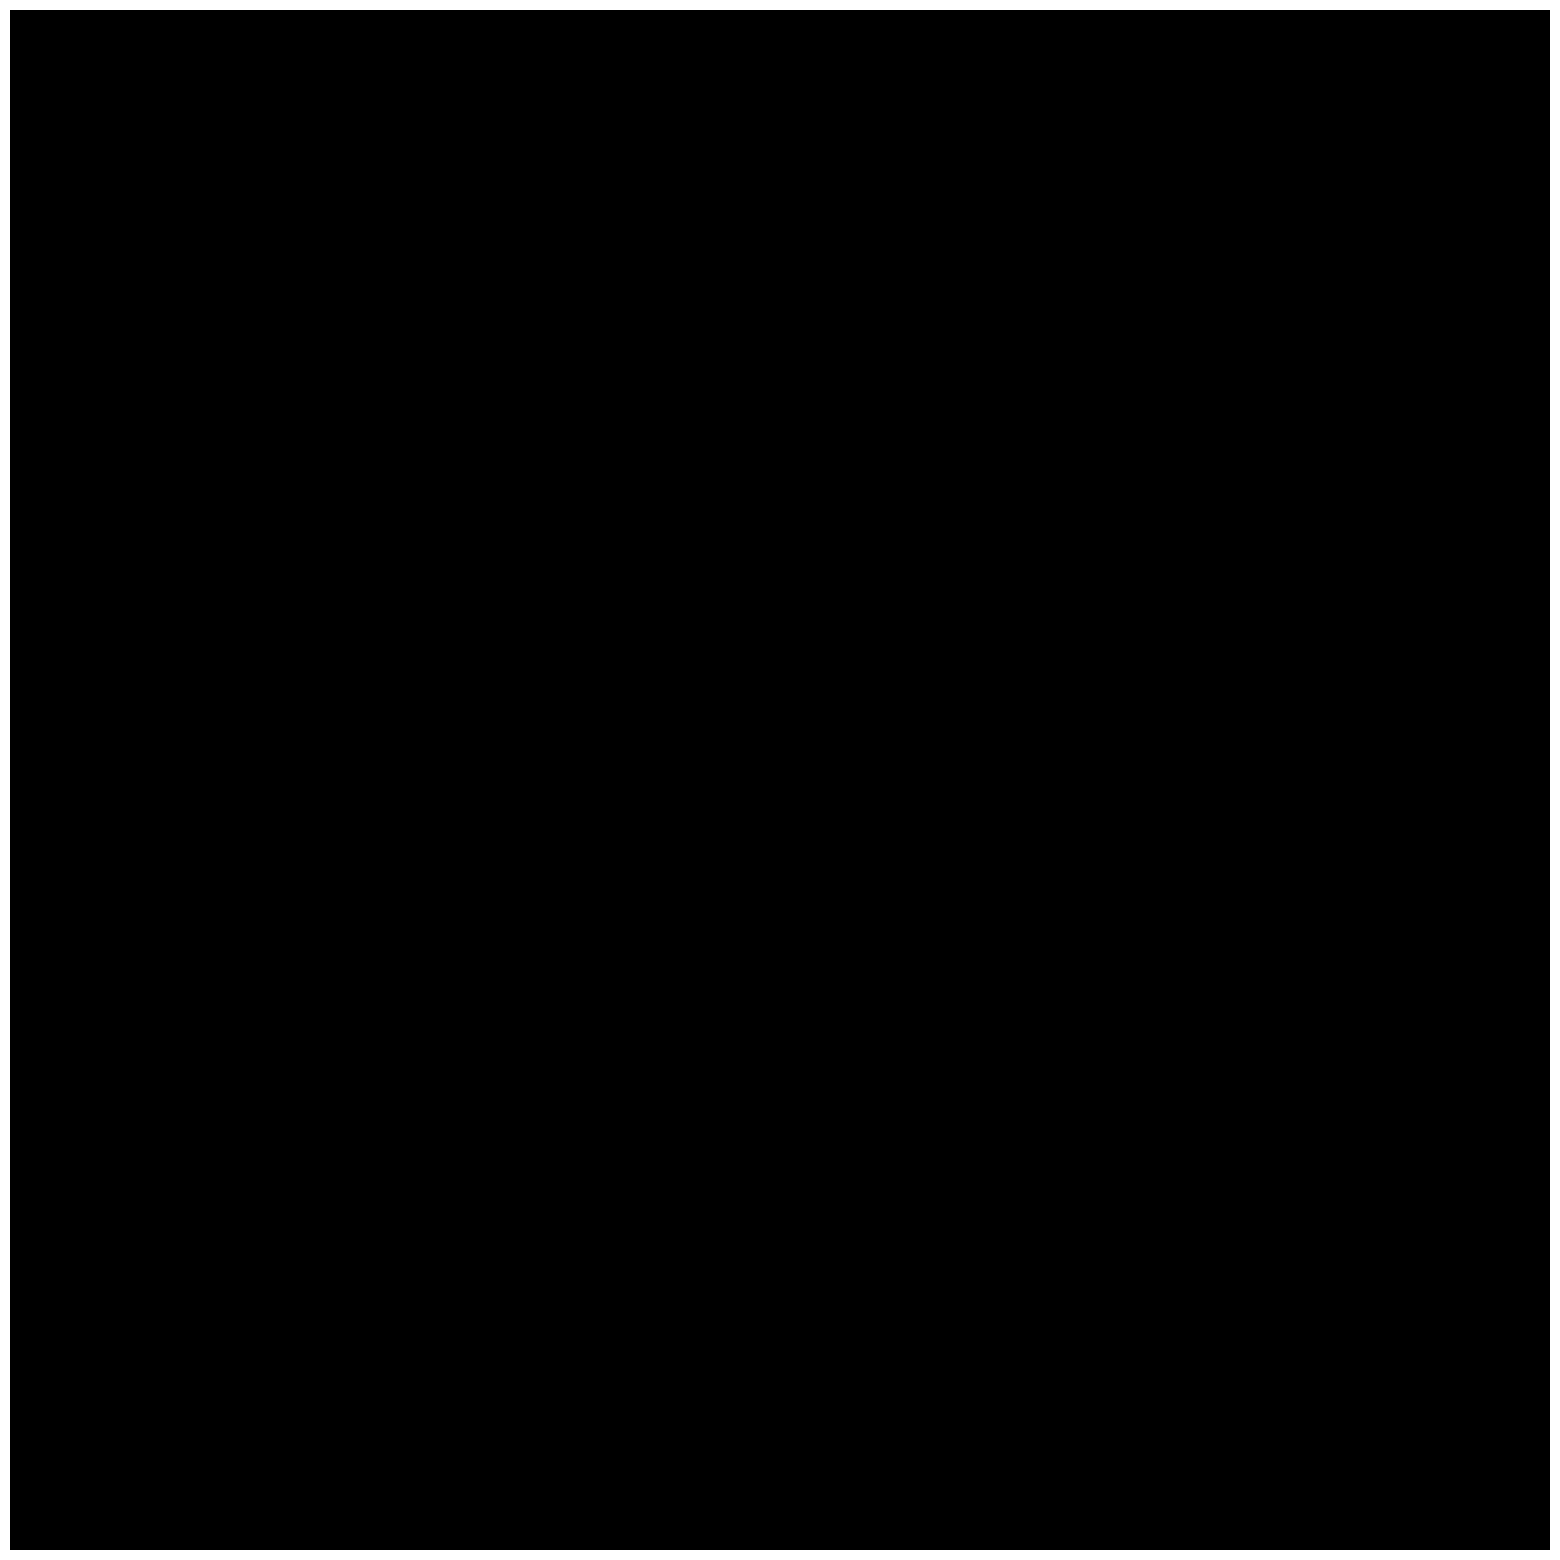

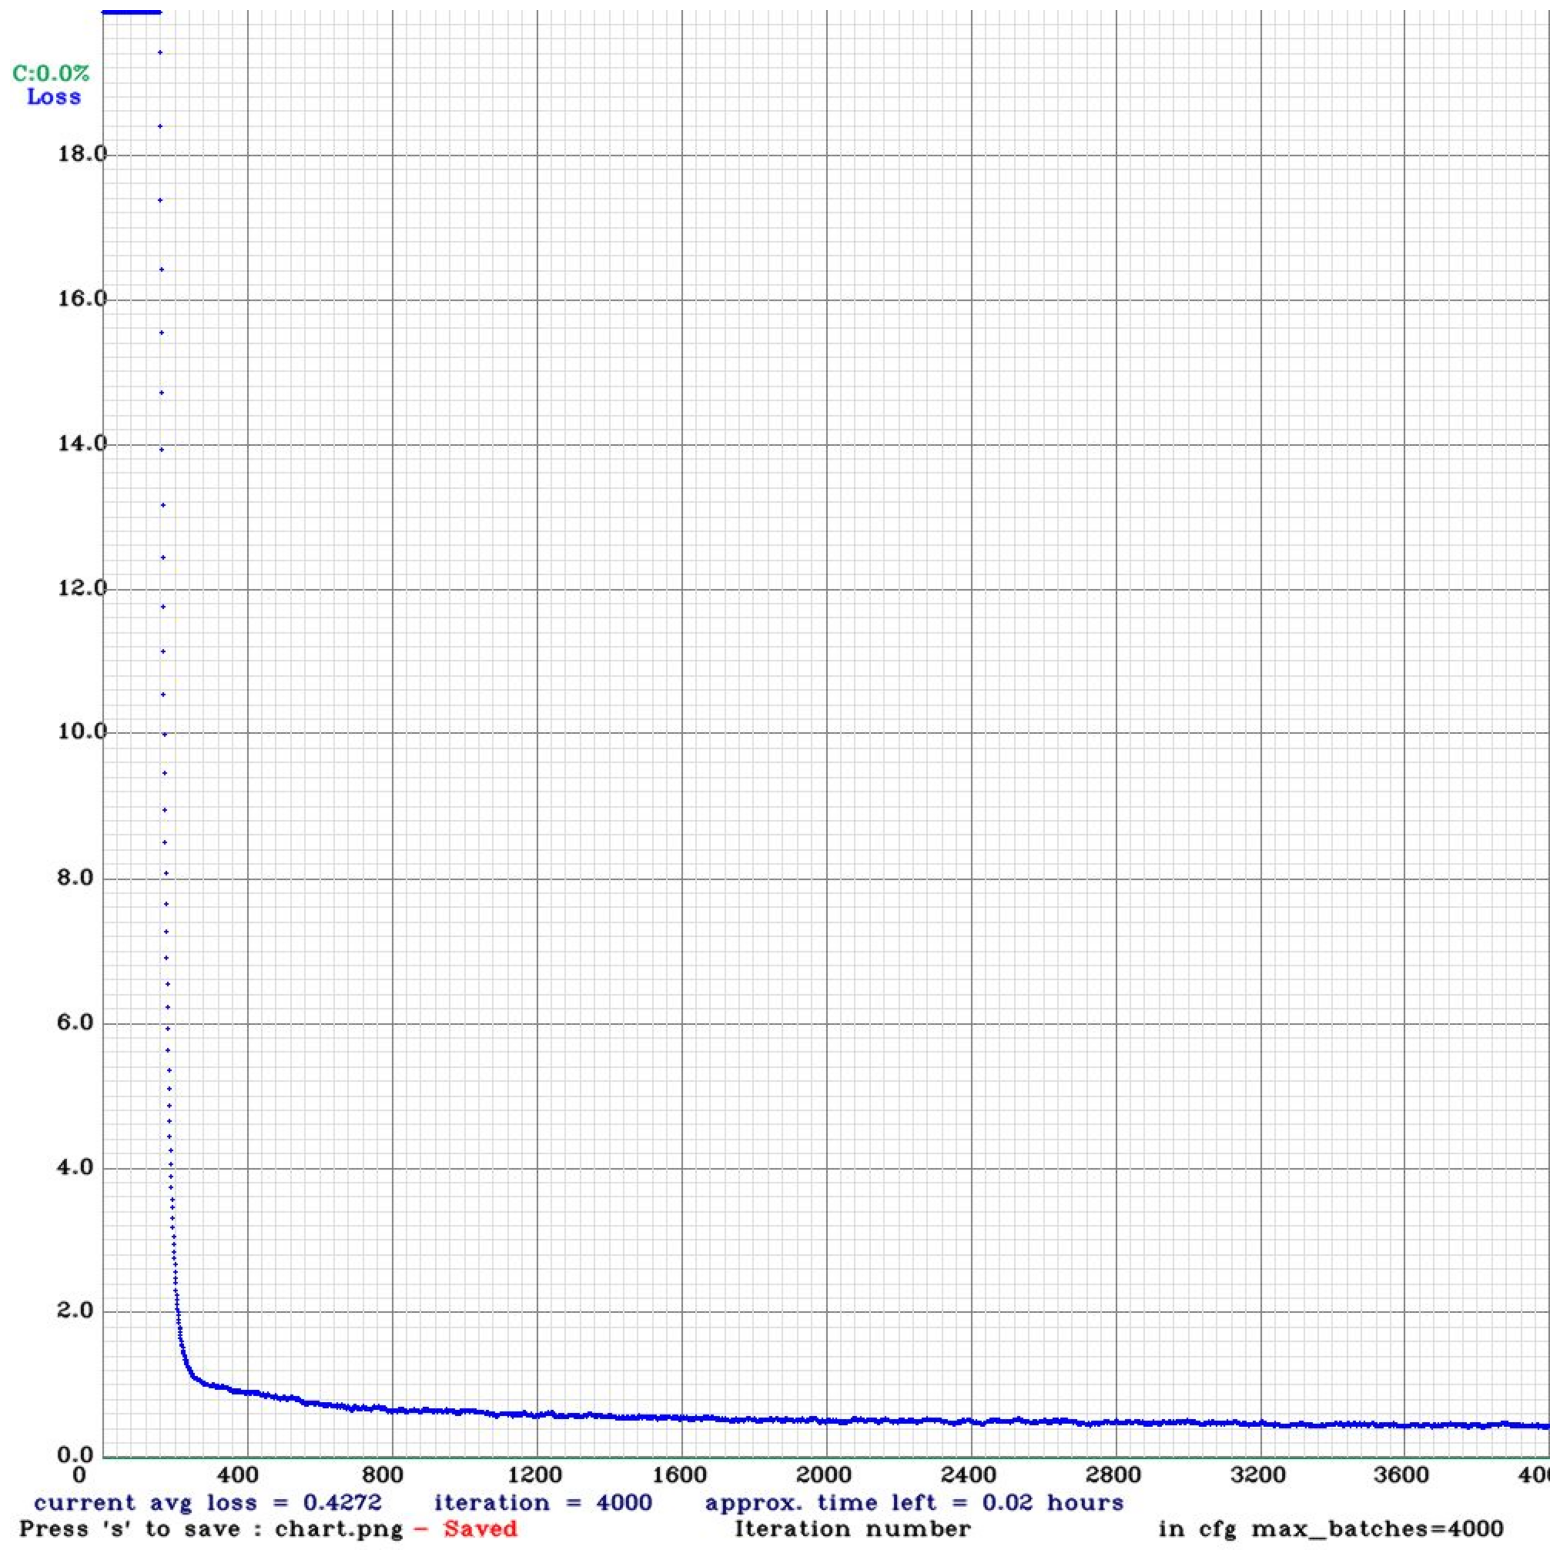

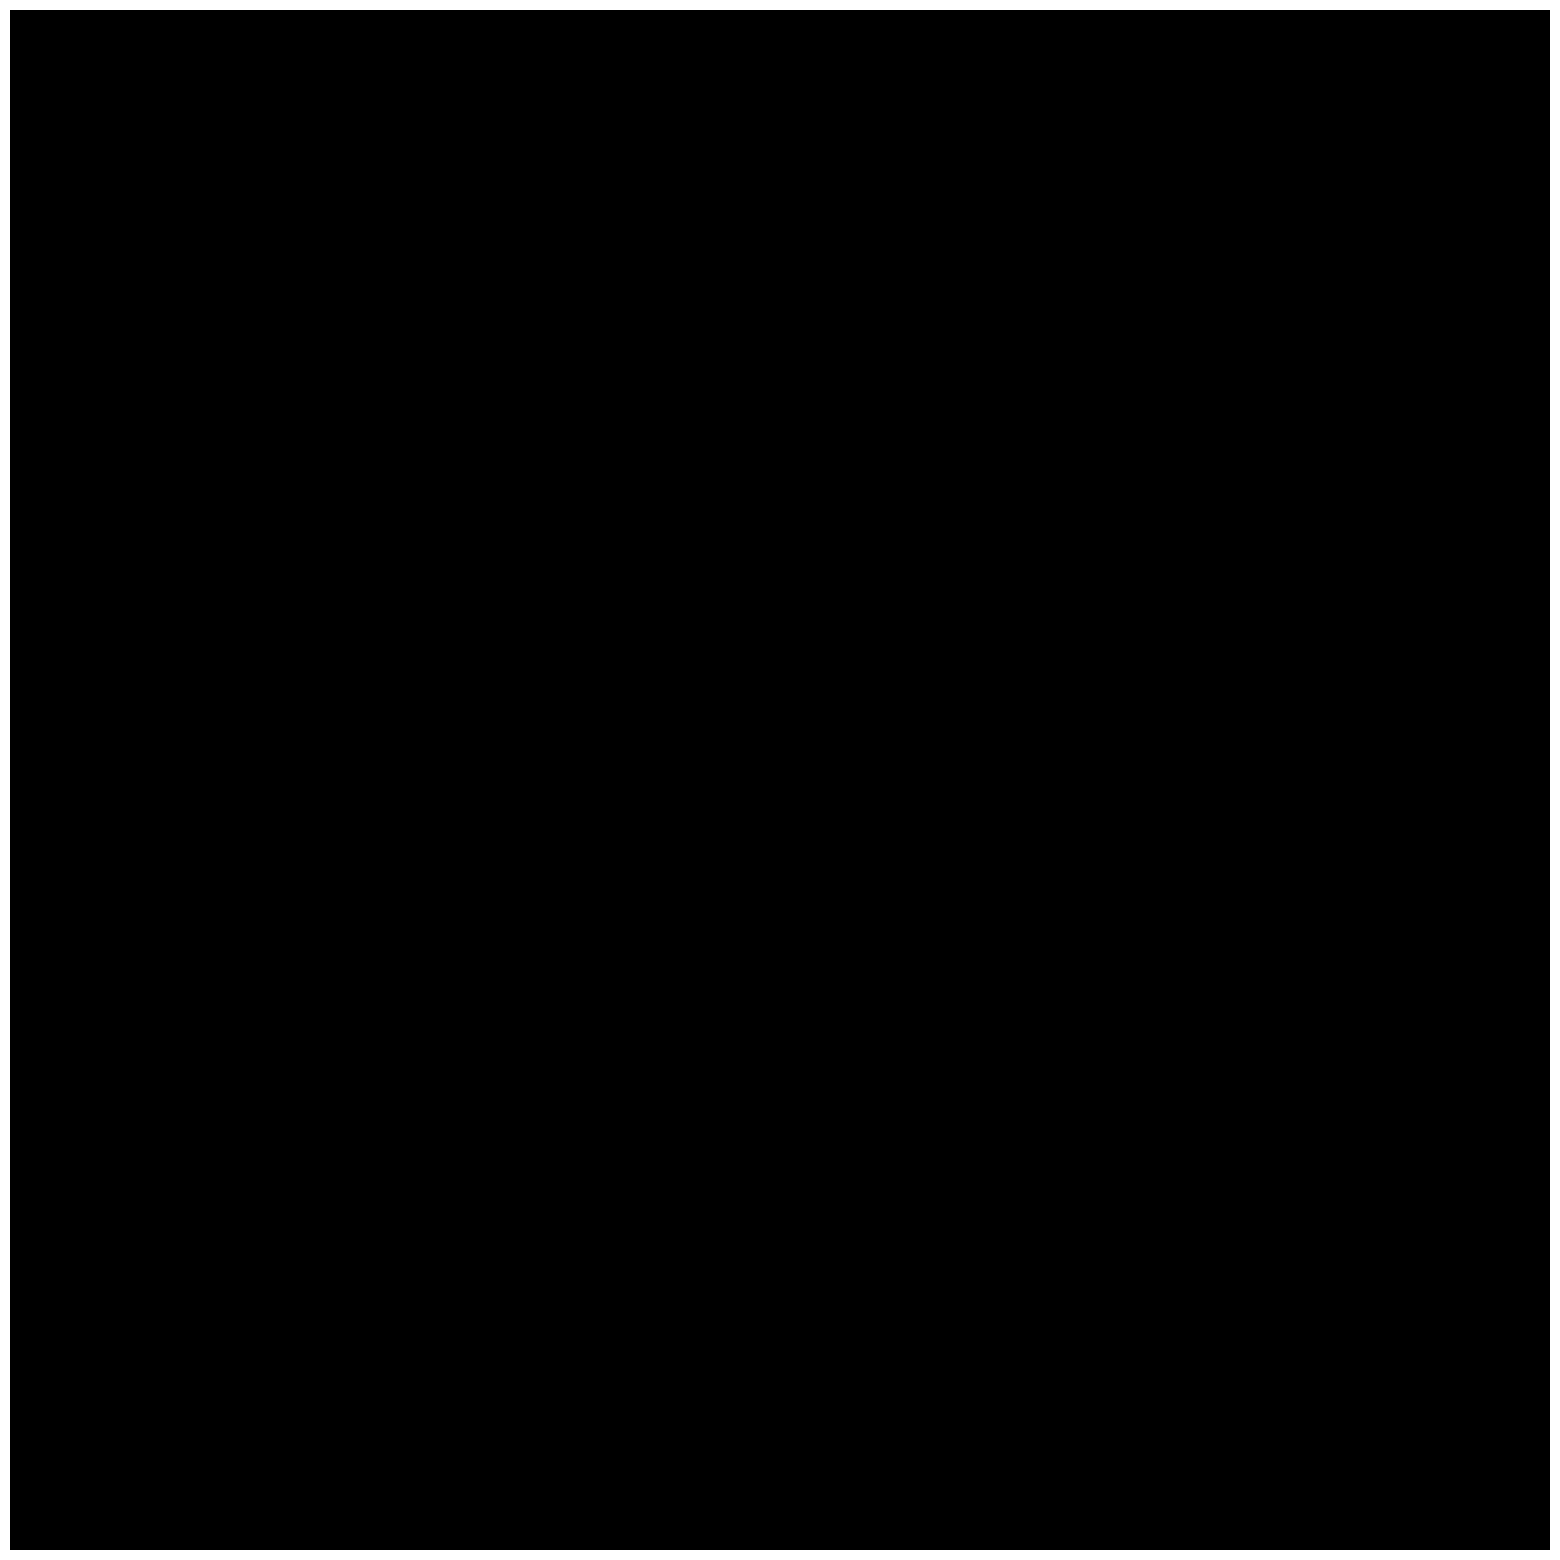

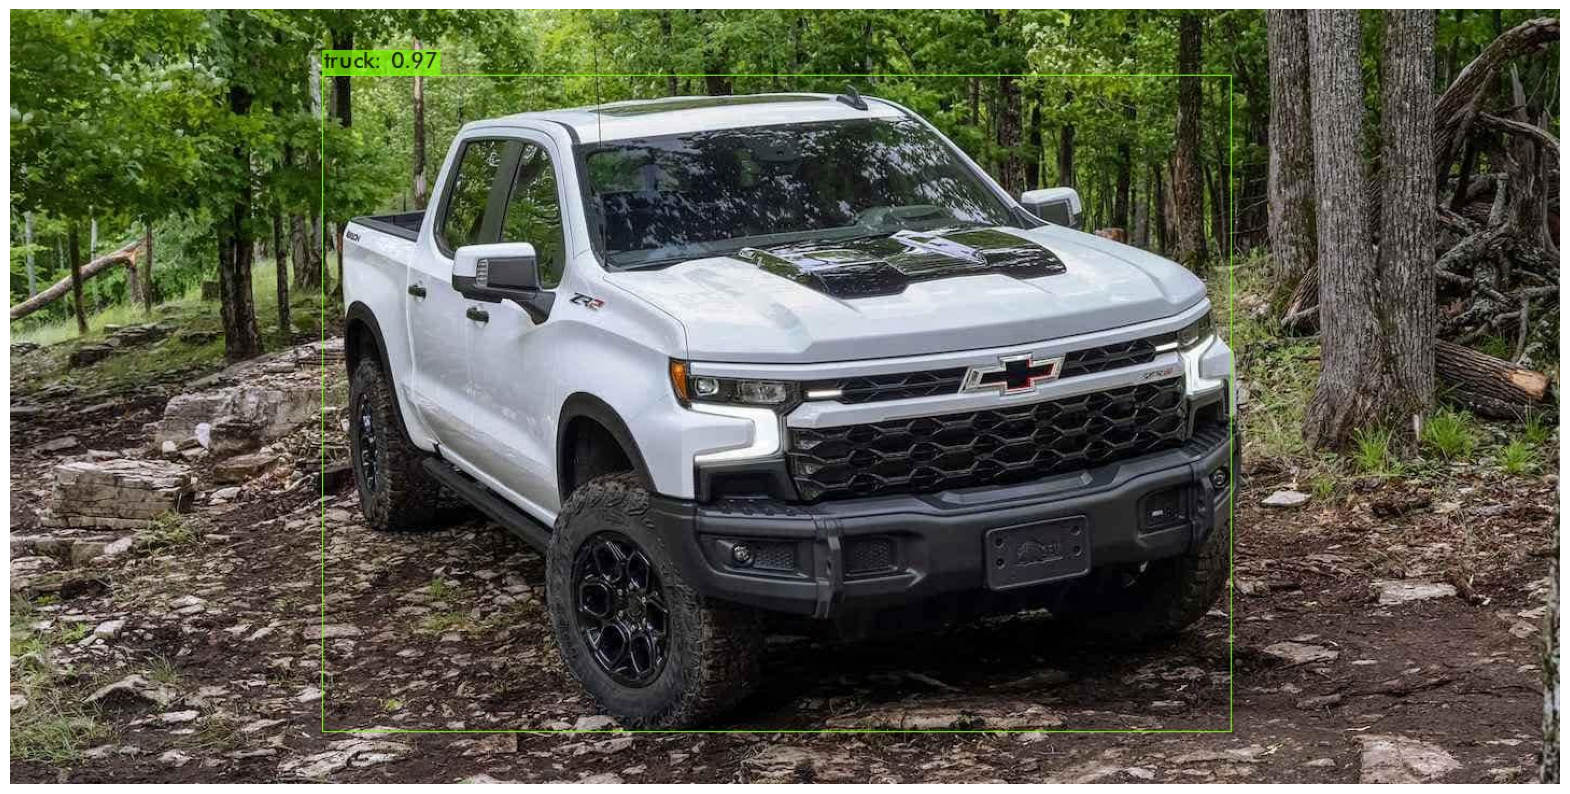

In [64]:
from torch_snippets import Glob, stem, show, read
# upload your own images to a folder
image_paths = Glob('images-of-trucks-and-busses')
for f in image_paths:
    !./darknet detector test data/obj.data cfg/yolov4-tiny-bus-trucks.cfg\
    backup/yolov4-tiny-bus-trucks_4000.weights {f}
    !mv predictions.jpg {stem(f)}_pred.jpg

for i in Glob('*_pred.jpg', silent=True):
    show(read(i, 1), sz=20)